In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
# import cv2
from tensorflow.contrib import layers
from scipy.misc import imresize
import math

In [2]:
BATCH_SIZE = 16

PYRAMID_LEVELS = 3
LAYERS_PER_LEVEL = 2
LEVEL_UPSCALE = 2 ** LAYERS_PER_LEVEL
MAX_SIZE = (LEVEL_UPSCALE ** PYRAMID_LEVELS)
print MAX_SIZE


64


In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}

image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    filename_q, attr_q = tf.train.slice_input_producer([filename_tensor, attr_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    # image = tf.image.rgb_to_grayscale(image)

    def resize_image(image):
        # image = tf.random_crop(image, [192, 160, 3])
        # return image
        image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
        img_reshaped = tf.reshape(image, [1, 160, 160, 3])
        image = tf.image.resize_bilinear(img_reshaped, [MAX_SIZE, MAX_SIZE])
        return tf.reshape(image, [MAX_SIZE, MAX_SIZE, 3])
    image = resize_image(image)

    def distort_image(image):
        # noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        # distorted_image = image + tf.random_uniform([64, 64, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    images_batch, attrs_batch = tf.train.shuffle_batch([distort_image(image), attr_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch, attrs_batch

images_batch, attrs_batch = create_qs(True)


In [4]:
initializer = tf.truncated_normal_initializer(0.00, 0.02)

def lrelu(x):
    # leaky relu
    alpha = 0.1
    return tf.maximum(alpha*x,x)

def identity(x): return x

def l2_loss(y, y_):
    return (y - y_) * (y - y_)

def resize_images_to_same_size(images, based_on):
    if based_on is None:
        return None
    else:
        _,h,w,_ = [d.value for d in based_on.get_shape()]
        return tf.image.resize_images(images, [h,w])

def avg(list):
    return sum(list) * 1.0 / len(list)

In [5]:

class Net(object):
    def __init__(self):
        self.global_step = tf.contrib.framework.get_or_create_global_step()
        
    session = None
    
    def setup(self, path=None):
        if self.session: self.session.close()
        self.session = tf.InteractiveSession()
        
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        self.session.run(init_op)
        tf.train.start_queue_runners(sess=self.session)
        
        self.saver = None
        self.path = path
        if path:
            if not os.path.exists(path):
                os.mkdir(path)
            self.saver = tf.train.Saver()
            ckpt = tf.train.get_checkpoint_state(path)
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(self.session, ckpt.model_checkpoint_path)
                print 'Restored from checkpoint', ckpt.model_checkpoint_path
            else:
                print 'Did not restore from checkpoint'
        else:
            print 'Will not save progress'
    
    def save(self):
        if self.saver:
            step_ = self.session.run(self.global_step)
            saver.save(session, self.path + '/model.ckpt', global_step=step_)
            print 'Saved'
    
    def train_step(self, verbose):
        # should return the current step
        assert False, 'train_step() not implemented'
    
    def train(self, print_every=2, save_every=100):
        while True:
            step_ = self.session.run(self.global_step)
            verbose = (step_ % print_every == 0)
            self.train_step(verbose)
            if step_ % save_every == 1:
                self.save()


In [11]:

Z_SIZE = 32
SCALING_L2_WEIGHT = 2

class Upscaler(object):
    def __init__(self, inputs, target_outputs):
        # upscalers for the same sizes will always share weights        
        _, big_h, big_w, c = [d.value for d in target_outputs.get_shape()]
        self.name = '{}x{}'.format(big_h,big_w)
        self.out_size = (big_h, big_w)
        
        self.fake_big = self.upscale(inputs)
        if inputs is not None:
            small_again = resize_images_to_same_size(self.fake_big, inputs)
            self.scaling_loss = tf.reduce_mean(l2_loss(inputs, small_again), axis=[1,2,3])
        else:
            self.scaling_loss = 0
        
        self.real_crit_score = self.critic(inputs, target_outputs)
        self.fake_crit_score = self.critic(inputs, self.fake_big)
        
    def upscale(self, small):
        # small can be None
        with tf.variable_scope('gen/' + self.name):
            z = tf.random_uniform([BATCH_SIZE, 1, 1, Z_SIZE], minval=-1, maxval=1)
            
            if small is None:
                img = z
            else:
                _, small_h, small_w, c = [d.value for d in small.get_shape()]
                z_tiled = tf.tile(z, [1, small_h, small_w, 1])
                img = tf.concat([small, z_tiled], 3)
            
            for i in xrange(LAYERS_PER_LEVEL):    
                n_channels = 32 * 2 ** (LAYERS_PER_LEVEL - 1 - i)
                img = layers.conv2d_transpose(img,
                          n_channels * 2, 
                          scope='up_'+str(i), 
                          kernel_size=4, 
                          activation_fn=lrelu, 
                          stride=2,
                          normalizer_fn=layers.batch_norm, 
                          weights_initializer=initializer)
            img = layers.conv2d(img, 
                    3, 
                    scope='final'+str(i),
                    kernel_size=1,
                    stride=1,
                    activation_fn=tf.tanh,
                    weights_initializer=initializer)
            return img
        
    def critic(self, small, big):
        # small can be None
        with tf.variable_scope('critic/' + self.name):
            if small is not None:
                # condition the critic on small:
                img = tf.concat([big, resize_images_to_same_size(small, big)], 3)
            else:
                img = big
            for i in xrange(LAYERS_PER_LEVEL):
                n_channels = 32 * 2**i
                norm = None if i == 0 else layers.batch_norm
                img = layers.conv2d(img, 
                                    n_channels, 
                                    scope='critic_'+str(i),
                                    kernel_size=5,
                                    stride=2,
                                    activation_fn=lrelu,
                                    normalizer_fn=norm, 
                                    weights_initializer=initializer)
            # once we've downsampled using convolution, a final layer computes critic scores across the image,
            # which are averaged:
            img = layers.conv2d(img,1,
                                scope='final_'+str(i),
                                kernel_size=5,
                                stride=1,
                                activation_fn=identity,
                                weights_initializer=initializer)
            return tf.reduce_mean(img, axis=[1,2,3])

def true_loss(output, is_true):
    return l2_loss(output, tf.ones_like(output) * (1 if is_true else -1))
        
class Pyramid(Net):
    def __init__(self, images_batch, scopename='pg'):
        super(Pyramid, self).__init__()
        self.critic_losses = []
        self.gen_losses = []
        with tf.variable_scope(scopename):
            self.upscalers = []
            for i in xrange(PYRAMID_LEVELS):
                in_size = LEVEL_UPSCALE ** i
                out_size = LEVEL_UPSCALE ** (i+1)
                inputs = None if i == 0 else tf.image.resize_images(images_batch, [in_size, in_size])
                outputs = tf.image.resize_images(images_batch, [out_size, out_size])
                u = Upscaler(inputs, outputs)
                self.upscalers.append(u)

            self.critic_loss = tf.reduce_mean([
                true_loss(u.fake_crit_score, False) + true_loss(u.real_crit_score, True)
                for u in self.upscalers])
            self.gen_loss = tf.reduce_mean([
                true_loss(u.fake_crit_score, True) + u.scaling_loss * SCALING_L2_WEIGHT
                for u in self.upscalers])

            critic_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/critic')
            gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/gen')

            self.train_gen = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(self.gen_loss, 
                                                                        var_list=gen_vars, 
                                                                        global_step=self.global_step)

            train_critic_op = tf.train.RMSPropOptimizer(0.0001).minimize(self.critic_loss, var_list=critic_vars)
            weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in critic_vars])
            self.train_critic = train_critic_op # tf.group(weight_clip_op, train_critic_op)
    
    def train_step(self, verbose):
        for _ in xrange(1):
            _, loss_ = self.session.run([self.train_critic, self.critic_loss])
            self.critic_losses.append(loss_)
        _, loss_, step_ = self.session.run([self.train_gen, self.gen_loss, self.global_step])
        self.gen_losses.append(loss_)
        if verbose:
            print '{}: gen loss: {}; disc loss: {}'.format(step_, avg(self.gen_losses), avg(self.critic_losses))
            self.gen_losses = []
            self.critic_losses = []
        
p = Pyramid(images_batch, scopename='pg16')
        
print 'ok'

ok


In [12]:
for u in p.upscalers:
    print u.fake_big.get_shape()

(16, 4, 4, 3)
(16, 16, 16, 3)
(16, 64, 64, 3)


In [13]:
p.setup()

Will not save progress


In [22]:
p.train(print_every=40)

2121: gen loss: 2.26435727645; disc loss: 1.10330996066
2161: gen loss: 2.33497138023; disc loss: 1.09000033587
2201: gen loss: 2.32054381669; disc loss: 1.08052256405
2241: gen loss: 2.31287916005; disc loss: 1.07830102742


KeyboardInterrupt: 

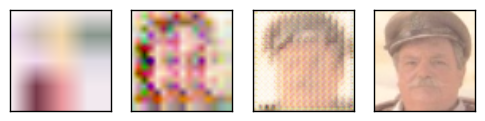

In [21]:
def show_sample():
    outs = []
    for u in p.upscalers:
        outs.append(tf.image.resize_images(u.fake_big, [MAX_SIZE, MAX_SIZE])[0])
    outs.append(images_batch[0])
    
    results = p.session.run(outs)
    
    imshow_multi(results)

show_sample()
